In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import codecs

from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score

In [21]:
sys.setrecursionlimit(1000000000)

In [22]:
%matplotlib inline
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (16, 7)})

In [23]:
arena_news_stem_df = pd.read_pickle('arena_news_stem_df.pkl')
sport_news_stem_df = pd.read_pickle('sport_news_stem_df.pkl')
jovem_news_stem_df = pd.read_pickle('jovem_news_stem_df.pkl')
arena_news_df = pd.read_pickle('arena_news_df.pkl')
sport_news_df = pd.read_pickle('sport_news_df.pkl')
jovem_news_df = pd.read_pickle('jovem_news_df.pkl')

In [24]:
labels = np.array(len(arena_news_df)*[1] + len(sport_news_df)*[0])

In [25]:
count_vect = CountVectorizer(encoding='UTF-8',lowercase=False, min_df=2)
X = count_vect.fit_transform(arena_news_df['all'].tolist() + sport_news_df['all'].tolist())

X_train_norm_tfidf = TfidfTransformer(norm=u'l2', use_idf=True).fit_transform(X)
X_train_norm = TfidfTransformer(norm=u'l2', use_idf=False).fit_transform(X)

In [38]:
def to_csv(some_list, file_name, header):
    def to_str(st):
        if isinstance(st, str) or isinstance(st, unicode):
            return st
        else:
            return str(st)
    with codecs.open(file_name, 'w', 'utf-8') as file_stream:
        if len(header) != 0:
            file_stream.write(u','.join(header) + '\n')
        for item in some_list:
            if isinstance(item, tuple) or isinstance(item, list):
                line = u','.join(map(to_str, item)) + '\n'
            else:
                line = item + '\n'
            file_stream.write(line)
    file_stream.close()

In [28]:
def _big_s(x, center):
    len_x = len(x)
    total = 0

    for i in range(len_x):
        total += np.linalg.norm(x[i]-center)

    return total / len_x

def davies_bouldin_score(X, labels_pred, k_centers):
    num_clusters, _ = k_centers.shape
    big_ss = np.zeros([num_clusters], dtype=np.float64)
    d_eucs = np.zeros([num_clusters, num_clusters], dtype=np.float64)
    db = 0

    for k in range(num_clusters):
        samples_in_k_inds = np.where(labels_pred == k)[0]
        samples_in_k = X[samples_in_k_inds, :]
        big_ss[k] = _big_s(samples_in_k, k_centers[k])

    for k in range(num_clusters):
        for l in range(0, num_clusters):
            d_eucs[k, l] = np.linalg.norm(k_centers[k]-k_centers[l])

    for k in range(num_clusters):
        values = np.zeros([num_clusters-1], dtype=np.float64)
        for l in range(0, k):
            values[l] = (big_ss[k] + big_ss[l])/d_eucs[k, l]
        for l in range(k+1, num_clusters):
            values[l-1] = (big_ss[k] + big_ss[l])/d_eucs[k, l]

        db += np.max(values)
    res = db / num_clusters
    return res

def calculate_centroids_doc_mean(X, labels_pred, k):
    _, m = X.shape

    centroids = np.zeros((k, m))
    for k in range(k):
        samples_in_k_inds = np.where(labels_pred == k)[0]
        centroids[k, :] = X[samples_in_k_inds, :].mean(axis=0)

    return centroids

In [18]:
def onmtf(X, U, S, V):
    U = U * ((X.dot(V).dot(S.T)) / (U.dot(S).dot(V.T).dot(X.T).dot(U)))
    V = V * ((X.T.dot(U).dot(S)) / (V.dot(S.T).dot(U.T).dot(X).dot(V)))
    S = S * ((U.T.dot(X).dot(V)) / (U.T.dot(U).dot(S).dot(V.T).dot(V)))
    return U, S, V

def onm3f(X, U, S, V):
     U = U * (X.dot(V).dot(S.T)) / np.sqrt(U.dot(U.T).dot(X).dot(V).dot(S.T))
     V = V * (X.T.dot(U).dot(S)) / np.sqrt(V.dot(V.T).dot(X.T).dot(U).dot(S))
     S = S * (U.T.dot(X).dot(V)) / np.sqrt(U.T.dot(U).dot(S).dot(V.T).dot(V))
     return U, S, V

def nbvd(X, U, S, V):
     U = U * (X.dot(V).dot(S.T)) / U.dot(U.T).dot(X).dot(V).dot(S.T)
     V = V * (X.T.dot(U).dot(S)) / V.dot(V.T).dot(X.T).dot(U).dot(S)
     S = S * (U.T.dot(X).dot(V)) / U.T.dot(U).dot(S).dot(V.T).dot(V)
     return U, S, V
    
def matrix_factorization_clustering(X, k, l, factorization_func=onmtf, norm=False, num_iters=100):
    m, n = X.shape
    U = np.random.rand(m,k)
    S = np.random.rand(k,l)
    V = np.random.rand(n,l)

    if norm:
        X = normalize(X)

    for i in xrange(num_iters):
        U, S, V = factorization_func(X, U, S, V)
        error = np.sum((X - U.dot(S).dot(V.T)) ** 2)
        print error

    Du = np.diag(np.ones(m).dot(U))
    Dv = np.diag(np.ones(n).dot(V))

    U = U.dot( np.diag(S.dot(Dv).dot(np.ones(l))) )
    V = V.dot( np.diag(np.ones(k).dot(Du).dot(S)) )

    rows_ind = np.argmax(U, axis=1)
    cols_ind = np.argmax(V, axis=1)

    return U, S, V, rows_ind, cols_ind, error

In [29]:
def matrix_factorization_overlapping_bin(X, k, l, num_iters=50):
    def weights_initialization(X, n, m, k):
        shuffle_inds = np.random.permutation(n)
        cluster_end_ind = 0
        for i in xrange(k):
            cluster_init_ind = cluster_end_ind
            cluster_end_ind = round((i + 1) * n / k)
            X[shuffle_inds[cluster_init_ind : cluster_end_ind], i] = 1
        return X

    def calculate_block_matrix(X, F, G, S, k, l):
        for i in xrange(k):
            for j in xrange(l):
                S[i, j] = np.mean(X[F[:, i] == 1][:, G[i][:, j] == 1])
        where_are_NaNs = np.isnan(S)
        S[where_are_NaNs] = 0
        return S

    n, m = X.shape

    F = weights_initialization(np.zeros((n, k)), n, m, k)

    G = []
    for i in xrange(k):
        G.append( weights_initialization(np.zeros((m, l)), m, n, l) )

    S = np.random.rand(k, l)

    for iter_ind in xrange(num_iters):
        S = calculate_block_matrix(X, F, G, S, k, l)

        for i in xrange(k):
            F_t = F[F[:, i] == 1, :].dot(S)
            X_t = X[F[:, i] == 1, :]
            G[i] = np.zeros((m, l))
            for j in xrange(m):
                clust_len, _ = X_t.shape
                diff = F_t - X_t[:, j].reshape(clust_len, 1).dot(np.ones(l).reshape(1, l))
                errors = np.diag(diff.T.dot(diff))
                minV = np.min(errors)
                index = np.where(errors <= minV)[0]
                G[i][j, index[np.random.randint(len(index))]] = 1

#         S = calculate_block_matrix(X, F, G, S, k, l)

        G_t = np.zeros((k, m))
        for i in xrange(k):
            G_t[i, :] = S[i, :].dot(G[i].T)

        F = np.zeros((n, k))
        for j in xrange(n):
            diff = G_t - np.ones(k).reshape(k, 1).dot(X[j, :].reshape(1, m))
            errors = np.diag(diff.dot(diff.T))
            minV = np.min(errors)
            index = np.where(errors <= minV)[0]
            F[j, index[np.random.randint(len(index))]] = 1

    G_t = np.zeros((k, m))
    for i in xrange(k):
        G_t[i, :] = S[i, :].dot(G[i].T)

    error = np.sum((X - F.dot(G_t))**2)

    rows_ind = np.argmax(F, axis=1)

    return F, S, G, G_t, rows_ind, error

In [10]:
def fnmtf(X, k, l, num_iter=100, norm=False):
    m, n = X.shape

    U = np.random.rand(m,k)
    S = np.random.rand(k,l)
    V = np.random.rand(n,l)

    if norm:
        X = preprocessing.normalize(X)
    for i in xrange(num_iter):
        S = np.linalg.pinv(U.T.dot(U)).dot(U.T).dot(X).dot(V).dot(np.linalg.pinv(V.T.dot(V)))

        # solve subproblem to update V
        U_tilde = U.dot(S)
        V_new = np.zeros(n*l).reshape(n, l)
        for j in xrange(n):
            errors = np.zeros(l)
            for col_clust_ind in xrange(l):
                errors[col_clust_ind] = ((X[:][:, j] - U_tilde[:][:, col_clust_ind])**2).sum()
            ind = np.argmin(errors)
            V_new[j][ind] = 1

        # solve subproblem to update U
        V_tilde = S.dot(V.T)
        U_new = np.zeros(m*k).reshape(m, k)
        for i in xrange(m):
            errors = np.zeros(k)
            for row_clust_ind in xrange(k):
                errors[row_clust_ind] = ((X[i][:] - V_tilde[row_clust_ind][:])**2).sum()
            ind = np.argmin(errors)
            U_new[i][ind] = 1

        U = U_new
        V = V_new

    rows_ind = np.argmax(U, axis=1)
    cols_ind = np.argmax(V, axis=1)

    return U, S, V, rows_ind, cols_ind

In [30]:
def rand_score(labels_true, labels_pred):
    return 'Rand score: %s' % adjusted_rand_score(labels_true, labels_pred)

def sil_score(X, labels_pred):
    score = silhouette_score(X, labels_pred)
    return 'Silhouette score: %s' % score

def db_score(X, labels_pred, k_centers):
    return 'Davies-Bouldin index: %s' % davies_bouldin_score(X, labels_pred, k_centers)

In [37]:
best = 0.0
for _ in xrange(5):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t, error = matrix_factorization_clustering(X_train_norm.toarray(), 2, 2, onmtf, num_iters=100)
    rand_sc = adjusted_rand_score(labels, rows_ind_t)
    if error > best:
        best = error
        U = U_t
        S = S_t
        V = V_t
        rows_ind = rows_ind_t
        cols_ind = cols_ind_t
    print 'tf norm: %s' % rand_score(labels, rows_ind_t)
    print 'tf norm: %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm: %s' % db_score(X_train_norm.toarray(), rows_ind_t, calculate_centroids_doc_mean(X_train_norm, rows_ind_t, 2))
    print ''

186.741902488
185.833675238
185.693099312
185.599353019
185.504889692
185.400892837
185.278171558
185.130951472
184.955041599
184.749201875
184.518247024
184.271349346
184.019132961
183.767489715
183.515800414
183.259073162
182.995380559
182.732632633
182.485481309
182.261222987
182.065534839
181.902966969
181.777389669
181.684672559
181.608874339
181.556693989
181.515404887
181.477668871
181.443751737
181.410835458
181.374380653
181.337757057
181.305300997
181.278666031
181.257805636
181.242828064
181.233019546
181.227244761
181.224478377
181.223449215
181.223238902
181.223325046
181.223490169
181.223551021
181.223428336
181.222837786
181.222294998
181.221791873
181.221250517
181.220532554
181.219650353
181.21846176
181.217018767
181.215302307
181.213477324
181.211638334
181.210011816
181.20859071
181.207438903
181.206455295
181.20567136
181.204984018
181.204429572
181.203915105
181.203485686
181.203062493
181.202706059
181.202348684
181.202049461
181.201738799
181.201473597
181.20119

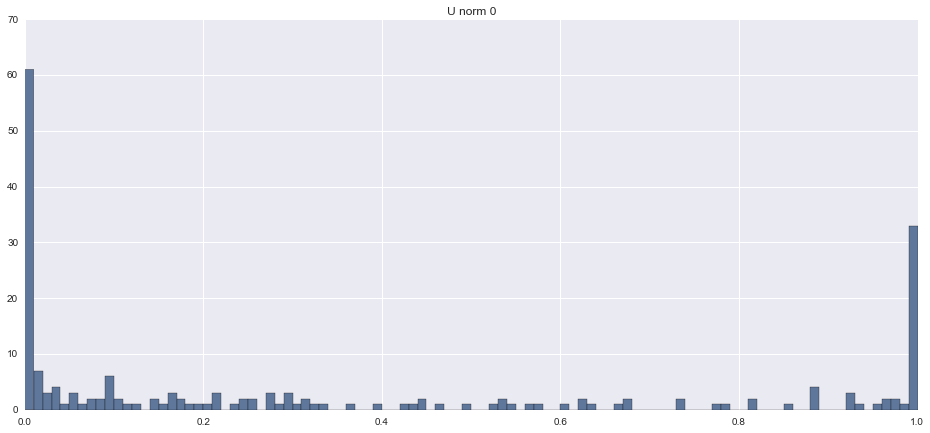

In [32]:
def print_hist(U):
    _, k = U.shape
    U_norm = U[:, 0] / np.sum(U, axis=1)

    plt.title('U norm 0')
    plt.hist(U_norm, bins=100)
    plt.show()
print_hist(U)

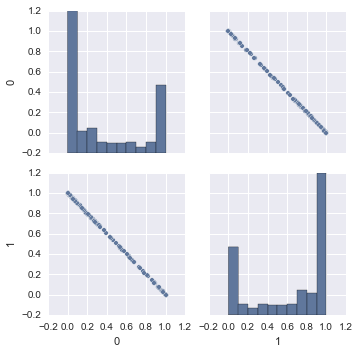

In [33]:
def norm(U):
    _, k = U.shape
    return U / np.tile(np.sum(U, axis=1).T, (k,1)).T
def pairplot(U):
    sns.pairplot(pd.DataFrame(norm(U)))
pairplot(U)

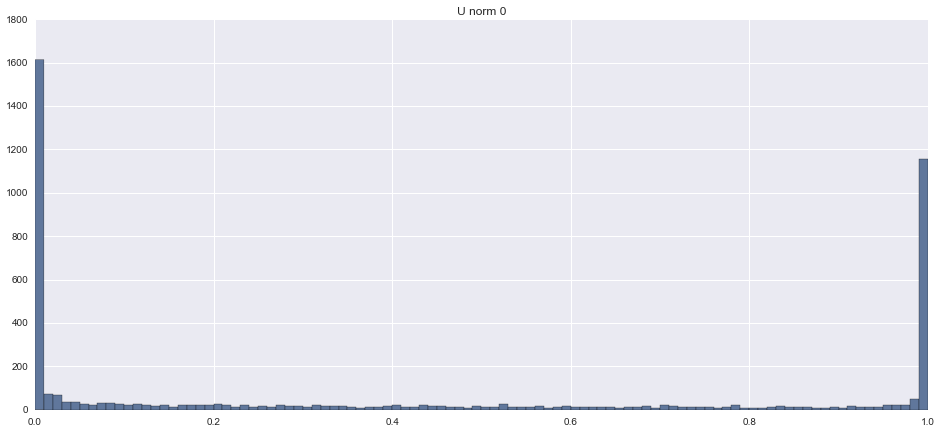

In [34]:
print_hist(V)

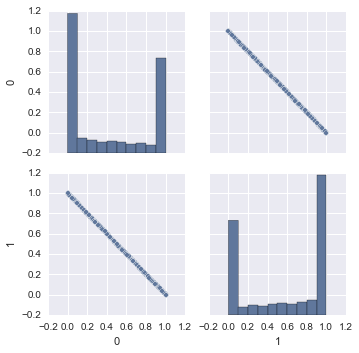

In [35]:
pairplot(V)

In [45]:
print S
np.savetxt('onmtf_2x2_S.csv', S, delimiter=",")

[[ 0.01647651  0.00017802]
 [ 0.00107611  0.01018368]]


In [41]:
def top_k(arr, k, axis=0):
    top_inds = np.argsort(arr, axis=axis)[-k:]
    top_vals = np.sort(arr, axis=axis)[-k:]
    return top_inds, top_vals

def reverse(arr):
    return arr[::-1]

def top_k_words_term_cluster(vec, X, count_vect, k):
    sum_per_word = np.sum(X, axis=0)
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    correspondence_vals = [sum_per_word[i] for i in top_inds]

    top_pairs = reverse(zip(top_words, top_vals, correspondence_vals))

    return top_pairs

V_norm = norm(V)
for i in xrange(2):
    print 'Top words for term cluster %s:' % i
    top_pairs = top_k_words_term_cluster(V[:, i], X_train_norm.toarray(), count_vect, 9999999)
    for w, v_value, tf_value in top_pairs[0:30]:
        print w, v_value, tf_value
    to_csv(top_pairs, 'onmtf_2x2_V%s_words_top.csv' % i, ['word', 'V cluster %s value' % i, 'tf norm value'])
    print

# print 'Top words for middle cluster:'
# inds = np.where((V_norm[:, 0] >= 0.25) & (V_norm[:, 0] <= 0.75))[0]
# normalize = np.vectorize(lambda x: 1.0 - x if x < 0.5 else x, otypes=[np.float])
# new_V0 = normalize(V_norm[inds, 0])
# top_k_words_term_cluster(new_V0, X_train_norm.toarray(), count_vect, 30)

Top words for term cluster 0:
jogo 19.3527267394 17.409134665
jogos 15.6353496953 14.0184074837
playstation 6.35047727335 6.50286252979
feira 6.07173171202 6.63423662207
novo 5.79390446145 6.4397883303
equipe 5.55833915879 5.38402375813
minutos 5.2089078997 4.59140755144
xbox 5.08179498493 5.93517551309
dia 5.07335915865 5.32093077415
game 5.00866710716 5.40202523592
time 5.00674944051 5.21085736446
dois 4.83620090059 4.46835594418
real 4.81827687176 4.27962701698
apenas 4.51116813321 4.59242923649
gol 4.50542691225 3.91517632453
anos 4.45772025754 4.91571457583
tempo 4.44838081005 4.3141804196
brasileiro 4.38930985302 4.87632646275
console 4.36396050274 4.56307259533
jogador 4.3587845406 4.68028023127
final 4.34828341839 4.9373205725
ano 4.29161837095 4.75079310834
título 4.21163516811 4.31037511355
monetáriointerno 4.20360363283 4.81840908599
segundo 4.18209501695 4.64121947369
jogadores 4.1802252545 4.30228612023
paulo 4.1686529716 4.23639183759
games 4.03979737147 5.41506727974
par

In [42]:
best_sil = 1e-10
best_davies = 1e10
for down_lim in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
    for up_lim in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        new_labels_pred = rows_ind.copy()
        inds = np.where((norm(U)[:,0] >= down_lim) & (norm(U)[:,0] <= up_lim))[0]
        
        if len(inds) == 0:
            continue
        
        print 'Num elems in new cluster: %s' % len(inds)
        new_labels_pred[inds] = 2

        print 'cluster from ' + str(down_lim) + ' to ' + str(up_lim)
        print sil_score(X_train_norm, new_labels_pred)
        print db_score(X_train_norm.toarray(), new_labels_pred, calculate_centroids_doc_mean(X_train_norm.toarray(), new_labels_pred, 3))
        print ''
        davies = davies_bouldin_score(X_train_norm.toarray(), new_labels_pred, calculate_centroids_doc_mean(X_train_norm.toarray(), new_labels_pred, 3))
        sil = silhouette_score(X_train_norm, new_labels_pred)
        if sil > best_sil and len(inds) is not 0:
            best_sil = sil
        if davies < best_davies and len(inds) is not 0:
            best_davies = davies
#         print '|[%s, %s]| %s | %s |' % (down_lim, up_lim, davies, sil)
print 'Best sil score: %s' % best_sil
print 'Best davies score: %s' % best_davies


Num elems in new cluster: 1
cluster from 0.05 to 0.15
Silhouette score: -0.000181088765606
Davies-Bouldin index: 1.86861073407

Num elems in new cluster: 1
cluster from 0.05 to 0.2
Silhouette score: -0.000181088765606
Davies-Bouldin index: 1.86861073407

Num elems in new cluster: 1
cluster from 0.05 to 0.25
Silhouette score: -0.000181088765606
Davies-Bouldin index: 1.86861073407

Num elems in new cluster: 1
cluster from 0.05 to 0.3
Silhouette score: -0.000181088765606
Davies-Bouldin index: 1.86861073407

Num elems in new cluster: 1
cluster from 0.05 to 0.4
Silhouette score: -0.000181088765606
Davies-Bouldin index: 1.86861073407

Num elems in new cluster: 2
cluster from 0.05 to 0.5
Silhouette score: 0.00408375773937
Davies-Bouldin index: 2.080683275

Num elems in new cluster: 2
cluster from 0.05 to 0.6
Silhouette score: 0.00408375773937
Davies-Bouldin index: 2.080683275

Num elems in new cluster: 4
cluster from 0.05 to 0.7
Silhouette score: 0.00878431186025
Davies-Bouldin index: 2.84835

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


|      Cut      |    Davies     | Silhouette  |
|:-------------:|:-------------:|:-----:|
|[0.05, 0.1]| 5.57285157009 | 0.0109045112115 |
|[0.05, 0.15]| 5.71182779465 | 0.0119656192241 |
|[0.05, 0.2]| 5.94127110479 | 0.0130751820341 |
|[0.05, 0.25]| 6.05298958519 | 0.0165451762916 |
|[0.05, 0.3]| 6.19170173754 | 0.0165380440629 |
|[0.05, 0.4]| 6.32245257561 | 0.0168367278657 |
|[0.05, 0.5]| 6.26966353994 | 0.0167316193288 |
|[0.05, 0.6]| 6.40807743382 | 0.016857356078 |
|[0.05, 0.7]| 6.4455544414 | 0.0172006814584 |
|[0.05, 0.75]| 6.55786721717 | 0.0172403307824 |
|[0.05, 0.8]| 6.56712481723 | 0.0171239228272 |
|[0.05, 0.85]| 6.64891705295 | 0.0172794978116 |
|[0.05, 0.9]| 6.65734610999 | 0.0175368723638 |
|[0.05, 0.95]| 6.43470626189 | 0.0185023158634 |
|**[0.1, 0.15]**| **3.74938336864** | 0.0200320140581 |
|[0.1, 0.2]| 4.95423215656 | 0.0122445704199 |
|[0.1, 0.25]| 5.24774207861 | 0.0189533279511 |
|[0.1, 0.3]| 5.4775435174 | 0.0184107763245 |
|[0.1, 0.4]| 5.64061493743 | 0.0188122752387 |
|[0.1, 0.5]| 5.70074585431 | 0.0180512491603 |
|[0.1, 0.6]| 5.89695453958 | 0.0183086502181 |
|[0.1, 0.7]| 5.99123959399 | 0.0187545346923 |
|[0.1, 0.75]| 6.16413919406 | 0.0189229292149 |
|[0.1, 0.8]| 6.21459398725 | 0.0187118565694 |
|[0.1, 0.85]| 6.36202785265 | 0.0193215518523 |
|[0.1, 0.9]| 6.38301325195 | 0.0198651799831 |
|[0.1, 0.95]| 6.27753852895 | 0.0214916194895 |
|[0.15, 0.2]| 4.86700812091 | 0.0105439794849 |
|[0.15, 0.25]| 5.11926762452 | 0.0185657354485 |
|[0.15, 0.3]| 5.37908380917 | 0.0180149889451 |
|[0.15, 0.4]| 5.52561494797 | 0.0185036943009 |
|[0.15, 0.5]| 5.5918038188 | 0.0176895051053 |
|[0.15, 0.6]| 5.8429610543 | 0.0179170884173 |
|[0.15, 0.7]| 5.94529904844 | 0.0184202374396 |
|[0.15, 0.75]| 6.1260691135 | 0.0186400603245 |
|[0.15, 0.8]| 6.18021555466 | 0.0184370429761 |
|[0.15, 0.85]| 6.34353934871 | 0.0191550753882 |
|[0.15, 0.9]| 6.38099084216 | 0.0197350762573 |
|[0.15, 0.95]| 6.27056371935 | 0.0214928456367 |
|[0.2, 0.25]| 4.59715750094 | 0.0258680002387 |
|[0.2, 0.3]| 4.80974711933 | 0.0231307008972 |
|[0.2, 0.4]| 4.95393026335 | 0.0226034756124 |
|[0.2, 0.5]| 5.10066417371 | 0.0204652333684 |
|[0.2, 0.6]| 5.40739503099 | 0.0200695117979 |
|[0.2, 0.7]| 5.56437964818 | 0.0205194066316 |
|[0.2, 0.75]| 5.80028313436 | 0.0207765470706 |
|[0.2, 0.8]| 5.92046824713 | 0.0203277378932 |
|[0.2, 0.85]| 6.28634021964 | 0.0211087702694 |
|[0.2, 0.9]| 6.34304665175 | 0.0218428354181 |
|[0.2, 0.95]| 6.18437325622 | 0.0237885594771 |
|[0.25, 0.3]| 4.22985981229 | 0.0135897730311 |
|[0.25, 0.4]| 4.61305561043 | 0.0164386610319 |
|[0.25, 0.5]| 4.76145280384 | 0.0130370501955 |
|[0.25, 0.6]| 4.89577281732 | 0.015318260869 |
|[0.25, 0.7]| 4.96585257909 | 0.0168170647366 |
|[0.25, 0.75]| 5.28245473331 | 0.0178483728072 |
|[0.25, 0.8]| 5.49589674625 | 0.0174806253808 |
|[0.25, 0.85]| 6.01445885302 | 0.0196945682697 |
|[0.25, 0.9]| 6.11307966306 | 0.0208421309285 |
|[0.25, 0.95]| 6.00289644331 | 0.0236550415501 |
|[0.3, 0.4]| 4.18386814443 | 0.0177595898038 |
|[0.3, 0.5]| 4.42658568564 | 0.0124694379783 |
|[0.3, 0.6]| 4.6461742013 | 0.0160554383447 |
|[0.3, 0.7]| 4.78111868642 | 0.017754651206 |
|[0.3, 0.75]| 4.94213034874 | 0.0188523697376 |
|[0.3, 0.8]| 5.11398707258 | 0.0183449197684 |
|[0.3, 0.85]| 5.77885390779 | 0.0205368208888 |
|[0.3, 0.9]| 5.90212574162 | 0.021749591286 |
|[0.3, 0.95]| 5.86506247584 | 0.0245266195333 |
|[0.4, 0.5]| 3.75873542708 | -0.00205947886867 |
|[0.4, 0.6]| 4.56282447318 | 0.0122479569878 |
|[0.4, 0.7]| 4.72491632079 | 0.0158173158729 |
|[0.4, 0.75]| 4.91515970836 | 0.0177338628519 |
|[0.4, 0.8]| 5.03705345485 | 0.0173025687048 |
|[0.4, 0.85]| 5.6129703548 | 0.0204270263155 |
|[0.4, 0.9]| 5.81215490242 | 0.0216658358824 |
|[0.4, 0.95]| 5.76329923942 | 0.0248179289182 |
|[0.5, 0.6]| 4.40042799038 | 0.0163728994807 |
|[0.5, 0.7]| 4.60320172881 | 0.0191154799039 |
|[0.5, 0.75]| 4.81979472845 | 0.0203328470184 |
|[0.5, 0.8]| 4.94125752597 | 0.0194989514475 |
|[0.5, 0.85]| 5.43863505151 | 0.0218455272703 |
|[0.5, 0.9]| 5.63343994389 | 0.022917219329 |
|[0.5, 0.95]| 5.65737212181 | 0.0256510868347 |
|[0.6, 0.7]| 4.19429867276 | 0.0207153509952 |
|[0.6, 0.75]| 4.5572477842 | 0.0219253916023 |
|[0.6, 0.8]| 4.71365451732 | 0.0203517172815 |
|[0.6, 0.85]| 5.25603888145 | 0.0221018824178 |
|[0.6, 0.9]| 5.5575547228 | 0.023039679348 |
|[0.6, 0.95]| 5.63857058938 | 0.0253660684729 |
|[0.7, 0.75]| 4.16919175321 | 0.0218116628449 |
|[0.7, 0.8]| 4.41973575661 | 0.0196048379769 |
|[0.7, 0.85]| 4.98999126621 | 0.0221993642761 |
|[0.7, 0.9]| 5.33295096418 | 0.0232778373442 |
|[0.7, 0.95]| 5.55578778726 | 0.0253850390862 |
|[0.75, 0.8]| 3.75847932539 | 0.013086650073 |
|[0.75, 0.85]| 4.8387599148 | 0.0219691396746 |
|[0.75, 0.9]| 5.06389873879 | 0.0233348449246 |
|[0.75, 0.95]| 5.42952171046 | 0.0255965371499 |
|[0.8, 0.85]| 4.80277799744 | 0.022240997867 |
|[0.8, 0.9]| 5.01524051316 | 0.0236135156815 |
|[0.8, 0.95]| 5.38384596029 | 0.0257300306828 |
|[0.85, 0.9]| 4.453963228 | 0.0227579527234 |
|[0.85, 0.95]| 5.21634727289 | 0.0240909201119 |
|[0.9, 0.95]| 5.07232266265 | 0.022501379554 |

- Best sil score: 0.0258680002387
- Best davies score: 3.74938336864

In [49]:
rows_inds_v1 = rows_ind.copy()
inds = np.where((norm(U)[:,0] >= 0.25) & (norm(U)[:,0] <= 0.75))[0]
rows_inds_v1[inds] = 2
rows_inds_v1

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [51]:
def top_k_words(vec, V, count_vect, k):
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    top_V_vals0 = [V[i, 0] for i in top_inds]
    top_V_vals1 = [V[i, 1] for i in top_inds]
    top_pairs = reverse(zip(top_words, top_V_vals0, top_V_vals1, top_vals))
    return top_pairs

for i in range(3):
    clust_inds = np.where(rows_inds_v1 == i)[0]
    sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
    print 'Top words for document cluster %s' % i
    top_pairs = top_k_words(sum_per_word, V, count_vect, 99999999)
    for word, v0_val, v1_val, tf_val in top_pairs[0:30]:
        print word, v0_val, v1_val, tf_val
    print
    to_csv(top_pairs, 'onmtf_2x2_doc_cluster_%s_words_top.csv' % i,
           ['word', 'V cluster 0 value', 'V cluster 1 value', 'tf norm value'])

Top words for document cluster 0
jogo 19.3527267394 1.87040747251e-05 16.1345006713
jogos 15.6353496953 1.54556249408e-23 13.7376085609
feira 6.07173171202 8.43601036208e-54 6.58016281503
playstation 6.35047727335 9.26734952961e-84 6.50286252979
novo 5.79390446145 3.34444164084e-25 6.2847611163
xbox 5.08179498493 4.02883885549e-45 5.93517551309
equipe 5.55833915879 8.9052424836e-19 5.13623838346
dia 5.07335915865 3.48601629221e-23 5.0844037314
anos 4.45772025754 4.26177288793e-48 4.87810570511
time 5.00674944051 0.111621677805 4.72817539153
brasileiro 4.38930985302 4.64107023359e-05 4.62058505134
game 5.00866710716 0.711428335873 4.59798879455
console 4.36396050274 7.26881670789e-34 4.56307259533
minutos 5.2089078997 5.05699831963e-75 4.5284134726
jogador 4.3587845406 1.11231646213e-39 4.51859855812
monetáriointerno 4.20360363283 8.70711420166e-05 4.39775037509
apenas 4.51116813321 1.45033620722e-08 4.39400299907
ano 4.29161837095 0.0741962269436 4.34858225763
dois 4.83620090059 1.7464

In [60]:
best = 1e10
for _ in xrange(5):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t, err = matrix_factorization_clustering(X_train_norm.toarray(), 3, 2, onmtf, num_iters=200)
    try:
        dav_sc = davies_bouldin_score(X_train_norm.toarray(), rows_ind_t, calculate_centroids_doc_mean(X_train_norm, rows_ind_t, 2))
    except:
        continue
    if err < best:
        best = err
        U_v2 = U_t
        S_v2 = S_t
        V_v2 = V_t
        rows_ind_v2 = rows_ind_t
        cols_ind_v2 = cols_ind_t

    print 'tf norm (3 clusters): %s' % rand_score(labels, rows_ind_t)
    print 'tf norm (3 clusters): %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm (3 clusters): %s' % dav_sc
    print ''

186.788029434
185.817753824
185.752988219
185.720605916
185.705301466
185.689326538
185.671233592
185.648633445
185.619951241
185.582805482
185.534095274
185.469286864
185.381833963
185.262094355
185.095854988
184.862370802
184.532235802
184.06652597
183.421616105
182.570813614
181.553035469
180.512382797
179.648646149
179.073448824
178.744195357
178.578415919
178.503513646
178.469384649
178.45321872
178.444949346
178.440765692
178.439196849
178.439076056
178.43951161
178.440044583
178.440472007
178.44075518
178.440879882
178.440897817
178.440869929
178.440841154
178.440813146
178.440798586
178.440784551
178.440774774
178.440754836
178.440731105
178.440691243
178.440642738
178.440574407
178.440495347
178.440395587
178.440285292
178.440155389
178.440017167
178.439861617
178.439699973
178.439525049
178.439351091
178.439170737
178.438994791
178.438812932
178.438635295
178.438452042
178.438273753
178.438090875
178.437913997
178.437733615
178.437560161
178.437384143
178.437215801
178.437045

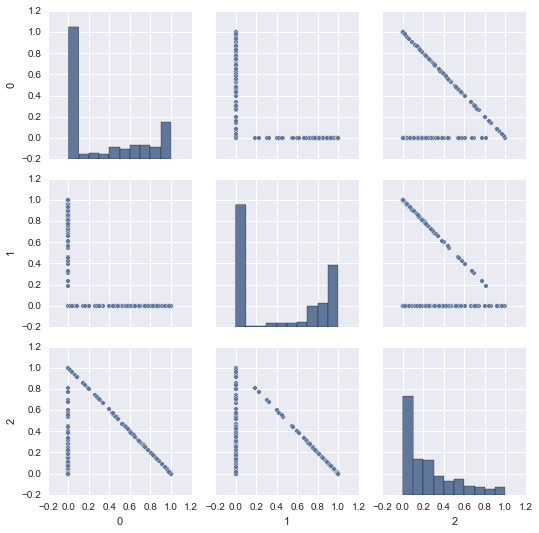

In [62]:
pairplot(U_v2)

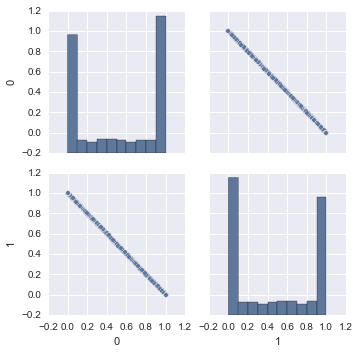

In [63]:
pairplot(V_v2)

In [64]:
def top_k_words_term_cluster(vec, X, count_vect, k):
    sum_per_word = np.sum(X, axis=0)
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    correspondence_vals = [sum_per_word[i] for i in top_inds]

    top_pairs = reverse(zip(top_words, top_vals, correspondence_vals))

    return top_pairs

V_norm_v2 = norm(V_v2)
for i in xrange(2):
    print 'Top words for term cluster %s:' % i
    top_pairs = top_k_words_term_cluster(V_v2[:, i], X_train_norm.toarray(), count_vect, 9999999)
    for w, v_value, tf_value in top_pairs[0:30]:
        print w, v_value, tf_value
    to_csv(top_pairs, 'onmtf_3x2_V%s_words_top.csv' % i, ['word', 'V cluster %s value' % i, 'tf norm value'])
    print

# print 'Top words for middle cluster:'
# inds = np.where((V_v2[:, 0] >= 0.1) & (V_v2[:, 0] <= 0.9))[0]
# normalize = np.vectorize(lambda x: 1.0 - x if x < 0.5 else x, otypes=[np.float])
# new_V0_v2 = normalize(V_norm_v2[inds, 0])
# print_top_k_words_term_cluster(new_V0_v2, X_train_norm.toarray(), count_vect, 30)

Top words for term cluster 0:
minutos 6.0219654876 4.59140755144
time 5.56443795011 5.21085736446
gol 5.44564709792 3.91517632453
equipe 5.43591353655 5.38402375813
feira 5.0468342517 6.63423662207
real 4.8959571162 4.27962701698
final 4.45302276018 4.9373205725
partida 4.35378666593 3.73445248798
anos 4.33175831968 4.91571457583
jogador 4.29710639867 4.68028023127
técnico 4.00316589002 3.56462451803
bola 4.00275093828 2.91680857213
breno 3.72058594244 3.34439260137
madrid 3.71996290024 2.75754288117
tempo 3.71033144923 4.3141804196
segundo 3.6439592259 4.64121947369
brasileiro 3.63295121434 4.87632646275
gols 3.62339025999 2.69286933272
espanha 3.61766825663 2.9656773629
paulo 3.59209003717 4.23639183759
casa 3.5807565964 3.40081430181
barcelona 3.57183286696 2.79061228958
campeonato 3.54549201074 3.42909922129
clube 3.53009271783 3.15377741762
dois 3.49856164701 4.46835594418
euro 3.38295209229 3.4981714608
atacante 3.37084143631 2.88981319147
vitória 3.19991256454 3.13423114506
espa

In [65]:
print S_v2
np.savetxt('onmtf_3x2_S.csv', S_v2, delimiter=",")

[[  5.79564771e-13   1.10211683e-02]
 [  1.15484454e-02   5.41819523e-07]
 [  3.40425870e-03   5.84742474e-03]]


In [76]:
def top_k_words(vec, V, count_vect, k):
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    top_V_vals0 = [V[i, 0] for i in top_inds]
    top_V_vals1 = [V[i, 1] for i in top_inds]
    top_pairs = reverse(zip(top_words, top_V_vals0, top_V_vals1, top_vals))
    return top_pairs

for i in range(3):
    clust_inds = np.where(rows_ind_v2 == i)[0]
    sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
    print 'Top words for document cluster %s' % i
    top_pairs = top_k_words(sum_per_word, V_v2, count_vect, 99999999)
    for word, v0_val, v1_val, tf_val in top_pairs[0:30]:
        print word, v0_val, v1_val, tf_val
    print
    to_csv(top_pairs, 'onmtf_3x2_doc_cluster_%s_words_top.csv' % i,
           ['word', 'V cluster 0 value', 'V cluster 1 value', 'tf norm value'])

Top words for document cluster 0
jogos 5.2628358465e-37 15.6021053817 9.76519927085
jogo 2.46034446107 15.1486973689 9.59369235669
playstation 1.55471293537e-137 7.03905261552 5.62782221729
of 6.11592831828e-53 6.59900252646 5.52687950299
xbox 2.07979873171e-150 5.88443728237 5.2046688083
novo 0.111285297763 5.13592376453 4.13033570305
wii 9.28801863374e-161 4.49740361187 3.86319063428
console 1.02870520391e-119 4.90395524015 3.635277187
sony 1.98897820995e-128 4.35586512114 3.55059854352
games 1.26106308682e-53 5.49220582005 3.44803608228
game 2.48202446885e-51 5.73830268997 3.37042744254
nintendo 5.14765332522e-133 3.56303369844 3.15125677327
the 1.60676425646e-77 3.95270818645 2.98369183214
lançado 3.03880564275e-47 2.7524348663 2.39865415406
legends 8.48662844341e-25 2.89624919289 2.32200005374
one 1.33822556732e-154 2.76835602248 2.30525013338
league 0.141365629411 2.91691472804 2.23854348135
ps 1.15788756457e-132 2.69766094543 2.09249974015
nova 1.88454541216e-09 2.57055086397 1.

In [61]:
print 'Num elems in cluster 0: %s' % np.sum(rows_ind_v2 == 0)
print 'Num elems in cluster 1: %s' % np.sum(rows_ind_v2 == 1)
print 'Num elems in cluster 2: %s' % np.sum(rows_ind_v2 == 2)
print rows_ind_v2
print np.where(rows_ind_v2 == 0)

for url in sport_news_df.ix[np.where(rows_ind_v2 == 0)[0]-100].url:
    print url

Num elems in cluster 0: 70
Num elems in cluster 1: 93
Num elems in cluster 2: 37
[2 2 2 2 2 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 2 0 2 0 2 0 0
 2 0 2 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0
 2 0 2 0 2 0 0 0 2 2 0 0 0 0 0 0 2 0 2 0 2 2 0 0 2 2 1 1 1 1 1 1 2 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1]
(array([ 5,  6,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 27, 29, 31, 33, 35, 36, 38, 40, 41, 42, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68,
       69, 70, 71, 73, 75, 77, 79, 80, 81, 84, 85, 86, 87, 88, 89, 91, 93,
       96, 97]),)
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
n

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,  91.]),
 array([ 0.65752947,  0.66437888,  0.67122829,  0.6780777 ,  0.68492711,
         0.69177652,  0.69862593,  0.70547534,  0.71232476,  0.71917417,
         0.72602358,  0.73287299,  0.7397224 ,  0.74657181,  0.75342122,
         0.76027063,  0.76712004,  0.77396945,  0.78081886,  0.78766827,
         0.79451768,  0.80136709,  0.8082165 ,  0.81506591,  0.82191532,
         0.82876474,  0.83561415,  0.84246356,  0.84931297,  0.85616238,
         0.86301179,  0.8698612 ,  0.87671061,  0.88356002,  0.89040943,
         0.89725884,  0.90410825,  0.91095766,  0.91780707,  0.92465648,
         0.93150589,  0.9383553 ,  0.94520472,  0.95205413,  0.95890354,
 

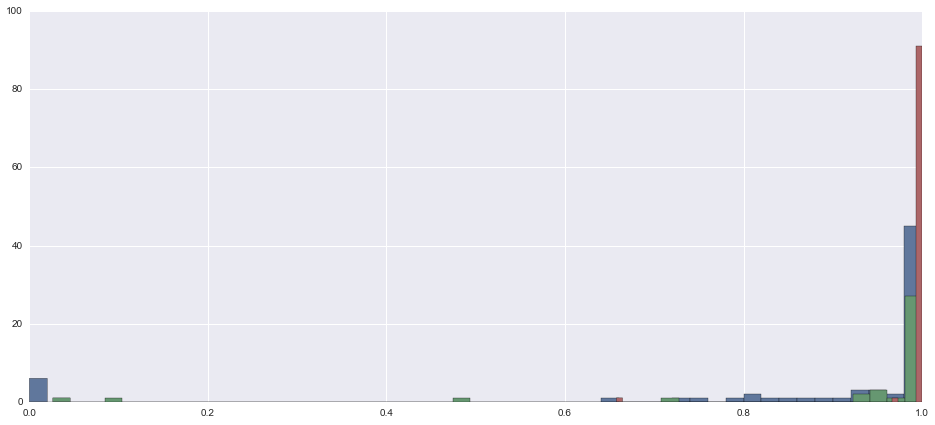

In [67]:
inds = np.where(rows_ind_v2 == 0)[0]
plt.hist(norm(U)[inds, 0], bins=50)

inds = np.where(rows_ind_v2 == 2)[0]
plt.hist(norm(U)[inds, 0], bins=50)

inds = np.where(rows_ind_v2 == 1)[0]
plt.hist(norm(U)[inds, 0], bins=50)

In [68]:
def overlap(a, b, k, l):
    clust_a = a == k
    clust_b = b == l
    
    inds = []
    sum_all = 0
    sum_equals = 0
    for i, elem in enumerate(clust_a):
        if (clust_a[i] == False and clust_b[i] == False):
            continue
        elif (clust_a[i] == True and clust_b[i] == False):
            sum_all += 1
        elif (clust_a[i] == False and clust_b[i] == True):
            sum_all += 1
        elif (clust_a[i] == True and clust_b[i] == True):
            sum_equals += 1
            sum_all += 1
            inds.append(i)
    return np.array(inds), float(sum_equals) / sum_all
print 'Do they overlap on cluster 2?'
inds, overlap_rate = overlap(rows_inds_v1, rows_ind_v2, 2, 0)
print '%.2f' % overlap_rate
print inds

Do they overlap on cluster 2?
0.04
[27 59 97]


In [69]:
best = 1e10
for _ in xrange(5):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t, err = matrix_factorization_clustering(X_train_norm.toarray(), 2, 3, onmtf, num_iters=100)
    try:
        dav_sc = davies_bouldin_score(X_train_norm.toarray(), rows_ind_t, calculate_centroids_doc_mean(X_train_norm, rows_ind_t, 2))
    except:
        continue
    if err < best:
        best = err
        U_v7 = U_t
        S_v7 = S_t
        V_v7 = V_t
        rows_ind_v7 = rows_ind_t
        cols_ind_v7 = cols_ind_t

    print 'tf norm (3 clusters): %s' % rand_score(labels, rows_ind_t)
    print 'tf norm (3 clusters): %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm (3 clusters): %s' % dav_sc
    print ''

186.628842362
185.79631509
185.708244154
185.665093932
185.625836634
185.579267021
185.519140637
185.438692309
185.328877636
185.176991896
184.965410239
184.671612817
184.271500749
183.749707182
183.115343919
182.408253973
181.681094201
180.981038504
180.350987228
179.817061248
179.394245821
179.09355749
178.89161793
178.761509513
178.673304848
178.607822801
178.556147548
178.513804115
178.478156165
178.447913278
178.422312545
178.400799512
178.383029037
178.368651158
178.357114085
178.347774613
178.340071151
178.333582685
178.328016179
178.323167048
178.318895193
178.315099006
178.311708865
178.308669648
178.305942254
178.303489616
178.301283664
178.299294066
178.297498487
178.295871884
178.294397447
178.293055375
178.291833704
178.290716753
178.289695848
178.288758
178.287896593
178.287100469
178.28636429
178.285678089
178.285037457
178.284434179
178.283866489
178.283329819
178.282824672
178.282346317
178.281893221
178.281460315
178.28104874
178.280658057
178.280292285
178.279950703


In [77]:
print S_v7
np.savetxt('onmtf_2x3_S.csv', S_v7, delimiter=",")

[[  1.08225705e-02   5.15201850e-03   4.14419833e-08]
 [  3.01304199e-09   5.54741882e-03   1.12429512e-02]]


In [78]:
# for i in range(2):
#     clust_inds = np.where(rows_ind_v7 == i)[0]
#     sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
#     print 'Top words for document cluster %s' % i
#     print_top_k_words(sum_per_word, count_vect, 20)
#     print
    
def top_k_words(vec, V, count_vect, k):
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    top_V_vals0 = [V[i, 0] for i in top_inds]
    top_V_vals1 = [V[i, 1] for i in top_inds]
    top_V_vals2 = [V[i, 2] for i in top_inds]
    top_pairs = reverse(zip(top_words, top_V_vals0, top_V_vals1, top_V_vals2, top_vals))
    return top_pairs

for i in range(2):
    clust_inds = np.where(rows_ind_v7 == i)[0]
    sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
    print 'Top words for document cluster %s' % i
    top_pairs = top_k_words(sum_per_word, V_v7, count_vect, 99999999)
    for word, v0_val, v1_val, v2_val, tf_val in top_pairs[0:30]:
        print word, v0_val, v1_val, v2_val, tf_val
    print
    to_csv(top_pairs, 'onmtf_2x3_doc_cluster_%s_words_top.csv' % i,
           ['word', 'V cluster 0 value', 'V cluster 1 value', 'V cluster 2 value', 'tf norm value'])

Top words for document cluster 0
time 4.9622283799 0.378989790529 3.04798988879e-18 4.75908187705
feira 2.84450333476 3.29197728789 1.25739102022e-09 4.53428093549
jogo 2.68012064069e-06 9.54459434012 9.13416718244 4.38957008659
equipe 3.88079422469 1.8548944296 7.08322956207e-10 4.29628349948
minutos 5.56732702575 0.0489029883654 1.87802106317e-32 4.28575586041
anos 3.0926080342 1.44630027839 2.91421864861e-11 3.98431219202
final 3.1173720191 1.76499255857 2.22444662667e-11 3.89212463999
jogador 3.1794197887 1.34777739113 2.41349868302e-18 3.86582870218
gol 5.09483149625 0.0030771716432 1.19014739596e-76 3.85918707343
ufc 1.97701600985 0.19934226238 9.66643021222e-28 3.81179311267
brasileiro 2.17189685808 2.29128914356 9.50006850351e-07 3.80965457051
técnico 3.77545717555 0.00445384446199 8.7458156854e-54 3.52244206397
euro 3.15211446617 0.00475976392425 6.71010940812e-68 3.4981714608
real 3.89946048651 1.12692603074 1.11850041269e-15 3.48278546656
partida 3.87646147421 0.405267249422

In [79]:
# V_norm_v7 = norm(V_v7)
# print 'Top words for term cluster 0:'
# print_top_k_words_term_cluster(V_v7[:, 0], X_train_norm.toarray(), count_vect, 30)
# print

# print 'Top words for term cluster 1:'
# print_top_k_words_term_cluster(V_v7[:, 1], X_train_norm.toarray(), count_vect, 30)
# print

# print 'Top words for term cluster 3:'
# print_top_k_words_term_cluster(V_v7[:, 2], X_train_norm.toarray(), count_vect, 30)
# print
def top_k_words_term_cluster(vec, X, count_vect, k):
    sum_per_word = np.sum(X, axis=0)
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    correspondence_vals = [sum_per_word[i] for i in top_inds]

    top_pairs = reverse(zip(top_words, top_vals, correspondence_vals))

    return top_pairs

V_norm_v7 = norm(V_v7)
for i in xrange(3):
    print 'Top words for term cluster %s:' % i
    top_pairs = top_k_words_term_cluster(V_v7[:, i], X_train_norm.toarray(), count_vect, 9999999)
    for w, v_value, tf_value in top_pairs[0:30]:
        print w, v_value, tf_value
    to_csv(top_pairs, 'onmtf_2x3_V%s_words_top.csv' % i, ['word', 'V cluster %s value' % i, 'tf norm value'])
    print

Top words for term cluster 0:
minutos 5.56732702575 4.59140755144
gol 5.09483149625 3.91517632453
time 4.9622283799 5.21085736446
real 3.89946048651 4.27962701698
equipe 3.88079422469 5.38402375813
partida 3.87646147421 3.73445248798
técnico 3.77545717555 3.56462451803
bola 3.74841879791 2.91680857213
madrid 3.48318607264 2.75754288117
gols 3.40497413538 2.69286933272
breno 3.3662150688 3.34439260137
espanha 3.36135431052 2.9656773629
barcelona 3.35500283792 2.79061228958
clube 3.29838519169 3.15377741762
jogador 3.1794197887 4.68028023127
campeonato 3.16035325763 3.42909922129
euro 3.15211446617 3.4981714608
atacante 3.14763983409 2.88981319147
final 3.1173720191 4.9373205725
anos 3.0926080342 4.91571457583
vitória 3.00153523226 3.13423114506
casa 2.9817865189 3.40081430181
espanhol 2.89649088263 2.41562175014
feira 2.84450333476 6.63423662207
futebol 2.78945398828 3.301483074
campeão 2.63985765534 3.27410639528
pontos 2.51667821799 2.27903941545
temporada 2.48282444604 2.8250591232
t

In [80]:
best = 1e10
for _ in xrange(5):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t, err = matrix_factorization_clustering(X_train_norm.toarray(), 3, 3, onmtf, num_iters=100)
    try:
        dav_sc = davies_bouldin_score(X_train_norm.toarray(), rows_ind_t, calculate_centroids_doc_mean(X_train_norm, rows_ind_t, 2))
    except:
        continue
    if err < best:
        best = err
        U_v6 = U_t
        S_v6 = S_t
        V_v6 = V_t
        rows_ind_v6 = rows_ind_t
        cols_ind_v6 = cols_ind_t

    print 'tf norm (3 clusters): %s' % rand_score(labels, rows_ind_t)
    print 'tf norm (3 clusters): %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm (3 clusters): %s' % dav_sc
    print ''

186.750051587
185.823986833
185.708864868
185.64825276
185.589197903
185.511041838
185.401041158
185.242579096
185.014534556
184.694177712
184.26351882
183.720742984
183.080446867
182.363931258
181.594134194
180.803326003
180.031871672
179.316772443
178.692237997
178.17975804
177.772635893
177.449660901
177.181691351
176.942372211
176.712693683
176.49372603
176.288804785
176.095775482
175.913224503
175.730193757
175.533342815
175.329373828
175.141724848
174.985152222
174.876244005
174.810731754
174.770346128
174.737666325
174.709031496
174.673345915
174.639468887
174.620693649
174.607084154
174.595389252
174.585691158
174.577529812
174.571056225
174.565281004
174.559912149
174.55482571
174.54994803
174.545264837
174.540980076
174.537209093
174.533923461
174.531020327
174.528464908
174.526228875
174.524275418
174.522527619
174.520935865
174.519441785
174.518018181
174.516642689
174.515337347
174.514131276
174.513076217
174.512190058
174.511476639
174.510905363
174.510450896
174.51007579

In [81]:
print S_v6
np.savetxt('onmtf_3x3_S.csv', S_v6, delimiter=",")

[[  9.64594493e-03   1.60029736e-05   7.54742212e-04]
 [  3.50749335e-04   2.89333310e-04   9.90929164e-03]
 [  1.95980724e-04   6.81620508e-03   4.98074508e-04]]


In [82]:
print 'Num elems in cluster 0: %s' % np.sum(rows_ind_v6 == 0)
print 'Num elems in cluster 1: %s' % np.sum(rows_ind_v6 == 1)
print 'Num elems in cluster 2: %s' % np.sum(rows_ind_v6 == 2)
print rows_ind_v6
print np.where(rows_ind_v6 == 1)

for url in arena_news_df.ix[np.where(rows_ind_v6 == 1)[0]].url:
    print url

Num elems in cluster 0: 100
Num elems in cluster 1: 91
Num elems in cluster 2: 9
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75, 76, 77, 78, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97, 98, 99]),)
http://arena.ig.com.br/2014-10-09/os-campeonatos-da-brasil-game-show.html
http://arena.ig.com.br/2014-

In [83]:
# for i in range(3):
#     clust_inds = np.where(rows_ind_v6 == i)[0]
#     sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
#     print 'Top words for document cluster %s' % i
#     print_top_k_words(sum_per_word, count_vect, 20)
#     print

def top_k_words(vec, V, count_vect, k):
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    top_V_vals0 = [V[i, 0] for i in top_inds]
    top_V_vals1 = [V[i, 1] for i in top_inds]
    top_V_vals2 = [V[i, 2] for i in top_inds]
    top_pairs = reverse(zip(top_words, top_V_vals0, top_V_vals1, top_V_vals2, top_vals))
    return top_pairs

for i in range(3):
    clust_inds = np.where(rows_ind_v6 == i)[0]
    sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
    print 'Top words for document cluster %s' % i
    top_pairs = top_k_words(sum_per_word, V_v6, count_vect, 99999999)
    for word, v0_val, v1_val, v2_val, tf_val in top_pairs[0:30]:
        print word, v0_val, v1_val, v2_val, tf_val
    print
    to_csv(top_pairs, 'onmtf_3x3_doc_cluster_%s_words_top.csv' % i,
           ['word', 'V cluster 0 value', 'V cluster 1 value', 'V cluster 2 value', 'tf norm value'])

Top words for document cluster 0
time 5.3490666498 0.208939169622 1.92855571961e-32 4.59686045592
feira 4.65459896169 7.60631043955e-45 1.08509025054 4.48020712845
jogo 1.69084664201 0.000114616167071 15.1011497435 4.38957008659
equipe 5.19876215793 0.000686774110747 0.00341105021503 4.29628349948
minutos 5.86925247263 2.76376134729e-71 3.969959487e-29 4.28575586041
anos 4.14056433179 5.37180947668e-37 0.015439981415 3.98431219202
jogador 4.15522433393 2.24388653384e-25 0.000371302105999 3.86582870218
gol 5.33363757159 5.57427691117e-123 6.51751170721e-48 3.85918707343
ufc 2.19096609625 2.25028536016e-54 9.35040292728e-21 3.81179311267
brasileiro 3.4972683835 0.0968838616214 0.448544084224 3.80965457051
final 4.17271655114 0.431452665599 1.84951879815e-10 3.67582941182
técnico 3.94282655569 8.1048055353e-113 7.4181951332e-42 3.52244206397
euro 3.31063623643 1.37877612795e-92 4.36377592434e-42 3.4981714608
real 4.77066245151 2.18492678698e-37 6.75588793299e-11 3.48278546656
breno 3.5717

In [84]:
# V_norm_v6 = norm(V_v6)
# print 'Top words for term cluster 0:'
# print_top_k_words_term_cluster(V_v6[:, 0], X_train_norm.toarray(), count_vect, 30)
# print

# print 'Top words for term cluster 1:'
# print_top_k_words_term_cluster(V_v6[:, 1], X_train_norm.toarray(), count_vect, 30)
# print

# print 'Top words for term cluster 3:'
# print_top_k_words_term_cluster(V_v6[:, 2], X_train_norm.toarray(), count_vect, 30)
# print
def top_k_words_term_cluster(vec, X, count_vect, k):
    sum_per_word = np.sum(X, axis=0)
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]
    correspondence_vals = [sum_per_word[i] for i in top_inds]

    top_pairs = reverse(zip(top_words, top_vals, correspondence_vals))

    return top_pairs

V_norm_v6 = norm(V_v6)
for i in xrange(3):
    print 'Top words for term cluster %s:' % i
    top_pairs = top_k_words_term_cluster(V_v6[:, i], X_train_norm.toarray(), count_vect, 9999999)
    for w, v_value, tf_value in top_pairs[0:30]:
        print w, v_value, tf_value
    to_csv(top_pairs, 'onmtf_3x3_V%s_words_top.csv' % i, ['word', 'V cluster %s value' % i, 'tf norm value'])
    print

Top words for term cluster 0:
minutos 5.86925247263 4.59140755144
time 5.3490666498 5.21085736446
gol 5.33363757159 3.91517632453
equipe 5.19876215793 5.38402375813
real 4.77066245151 4.27962701698
feira 4.65459896169 6.63423662207
partida 4.25770107094 3.73445248798
final 4.17271655114 4.9373205725
jogador 4.15522433393 4.68028023127
anos 4.14056433179 4.91571457583
técnico 3.94282655569 3.56462451803
bola 3.92353658497 2.91680857213
madrid 3.65962586907 2.75754288117
breno 3.57179712027 3.34439260137
gols 3.56922723254 2.69286933272
espanha 3.53718166993 2.9656773629
barcelona 3.51303539717 2.79061228958
tempo 3.49876036865 4.3141804196
brasileiro 3.4972683835 4.87632646275
clube 3.48087970499 3.15377741762
casa 3.44952614184 3.40081430181
segundo 3.44206600867 4.64121947369
campeonato 3.43378072393 3.42909922129
paulo 3.34764499261 4.23639183759
atacante 3.31635129254 2.88981319147
euro 3.31063623643 3.4981714608
dois 3.24453803467 4.46835594418
vitória 3.16074187952 3.13423114506
e

In [195]:
best = 1e1000
for _ in xrange(5):
    U_t, S_t, V_t, rows_ind_t, cols_ind_t, err = matrix_factorization_clustering(X_train_norm.toarray(), 2, 6, onmtf, num_iters=100)
    try:
        dav_sc = davies_bouldin_score(X_train_norm.toarray(), rows_ind_t, calculate_centroids_doc_mean(X_train_norm, rows_ind_t, 2))
    except:
        continue
    if err < best:
        best = err
        U_v8 = U_t
        S_v8 = S_t
        V_v8 = V_t
        rows_ind_v8 = rows_ind_t
        cols_ind_v8 = cols_ind_t

    print 'tf norm (3 clusters): %s' % rand_score(labels, rows_ind_t)
    print 'tf norm (3 clusters): %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm (3 clusters): %s' % dav_sc
    print ''

199.995888398
30584765.5334
199.980710871
31857910.8798
199.980408996
32477867.1875
199.979869101
33835307.205
199.978596575
36860845.4386
199.976220781
41053307.3486
199.97385157
44202215.2593
199.972385732
45971486.8297
199.971613461
46921880.3051
199.971208621
47421400.0233
199.971012859
47649810.1281
199.970925914
47751352.886
199.970883906
47802984.6097
199.970860038
47834429.5611
199.970843951
47856572.4179
199.970832114
47873108.7241
199.970823026
47885832.3465
199.970815905
47895748.1729
199.970810273
47903530.4171
199.970805776
47909695.8615
199.970802144
47914642.3155
199.970799174
47918662.8723
199.970796719
47921971.1214
199.970794669
47924723.6923
199.970792942
47927037.1414
199.970791477
47928999.7326
199.970790224
47930679.323
199.970789145
47932128.5925
199.970788208
47933388.5916
199.970787392
47934491.255
199.970786675
47935461.2757
199.970786043
47936317.5705
199.970785486
47937074.4814
199.970784995
47937742.8087
199.970784562
47938330.7318
199.970784183
47938844.63

In [196]:
S_v8

array([[  1.48050495e+00,   6.20737393e-04,   6.21261309e+00,
          3.01197767e+00,   7.98542506e+00,   5.78253851e+00],
       [  1.01302217e+01,   7.57536505e+00,   1.53444256e+00,
          1.21718146e-08,   1.27218932e-01,   1.73766868e-03]])

In [197]:
for i in range(2):
    clust_inds = np.where(rows_ind_v8 == i)[0]
    sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
    print 'Top words for document cluster %s' % i
    print_top_k_words(sum_per_word, count_vect, 20)
    print

Top words for document cluster 0
time - 4.75908187705
feira - 4.53428093549
jogo - 4.38957008659
equipe - 4.29628349948
minutos - 4.28575586041
anos - 3.98431219202
final - 3.89212463999
jogador - 3.86582870218
gol - 3.85918707343
ufc - 3.81179311267
brasileiro - 3.80965457051
técnico - 3.52244206397
euro - 3.4981714608
real - 3.48278546656
partida - 3.44447485976
breno - 3.34439260137
campeonato - 3.26537799981
futebol - 3.26424112787
campeão - 3.19254552377
vitória - 3.09937333634

Top words for document cluster 1
jogo - 13.0195645784
jogos - 12.3527084592
playstation - 6.50286252979
of - 6.26876796242
xbox - 5.93517551309
games - 5.30691966565
game - 5.29370574087
novo - 4.93748565046
console - 4.56307259533
sony - 4.15619803355
the - 3.97710024088
wii - 3.89686450689
brasil - 3.64522678256
nintendo - 3.27248181662
legends - 2.9094926904
league - 2.88202536911
apenas - 2.82897655817
one - 2.70936450188
dia - 2.64115950042
lançado - 2.55713526763



In [198]:
V_norm_v8 = norm(V_v8)
for l in xrange(6):
    print 'Top words for term cluster %s:' % l
    print_top_k_words_term_cluster(V_v8[:, l], X_train_norm.toarray(), count_vect, 30)
    print

Top words for term cluster 0:
jogo - 17726.4851177 - 17.409134665
jogos - 13979.3946256 - 14.0184074837
novo - 6725.96447288 - 6.4397883303
game - 6512.16690078 - 5.40202523592
playstation - 5114.53270594 - 6.50286252979
the - 5068.97001411 - 4.10855529243
brasil - 4183.55893834 - 4.75295749281
games - 4140.75629541 - 5.41506727974
apenas - 3774.99656302 - 4.59242923649
league - 3611.0351212 - 3.75349938375
of - 3145.3711387 - 6.66858864083
pessoas - 3124.53704712 - 2.5572955834
jogadores - 3072.53398899 - 4.30228612023
legends - 2983.2374014 - 3.23393553266
mil - 2961.01777508 - 2.67438462566
dia - 2852.9273413 - 5.32093077415
lançamento - 2813.5486133 - 2.57362895081
nova - 2604.81630397 - 3.08765693943
ps - 2577.16787817 - 2.46754638865
sony - 2524.69689224 - 4.15619803355
melhor - 2437.81448081 - 4.04988727448
wii - 2352.02890568 - 3.89686450689
durante - 2328.8697535 - 3.25896696005
xbox - 2282.27938936 - 5.93517551309
usmonetáriointerno - 2085.92572837 - 2.62675989352
evento - 20

In [138]:
best = 1e10
for _ in xrange(5):
    U_t, S_t, V_t, V_t_t, rows_ind_t, error = matrix_factorization_overlapping_bin(X_train_norm.toarray(), 2, 2, num_iters=100)
    try:
        dav_sc = davies_bouldin_score(X_train_norm.toarray(), rows_ind_t, calculate_centroids_doc_mean(X_train_norm, rows_ind_t, 2))
    except:
        continue
    if error < best:
        best = error
        U_v3 = U_t
        S_v3 = S_t
        V_v3 = V_t
        V_t_v3 = V_t_t
        rows_ind_v3 = rows_ind_t

    print 'tf norm (2 clusters): %s' % rand_score(labels, rows_ind_t)
    print 'tf norm (2 clusters): %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm (2 clusters): %s' % dav_sc
    print ''

tf norm (3 clusters): Rand score: 0.704151382448
tf norm (3 clusters): Silhouette score: 0.0293431281723
tf norm (3 clusters): 5.2907157964

tf norm (3 clusters): Rand score: 0.000410251253819
tf norm (3 clusters): Silhouette score: 0.00870302972305
tf norm (3 clusters): 3.68778616632

tf norm (3 clusters): Rand score: 0.827238885682
tf norm (3 clusters): Silhouette score: 0.0286723769638
tf norm (3 clusters): 5.37117320592

tf norm (3 clusters): Rand score: -0.00019704344349
tf norm (3 clusters): Silhouette score: 0.0151481673327
tf norm (3 clusters): 3.08164548957

tf norm (3 clusters): Rand score: 0.979999505051
tf norm (3 clusters): Silhouette score: 0.031862446603
tf norm (3 clusters): 5.16923685599



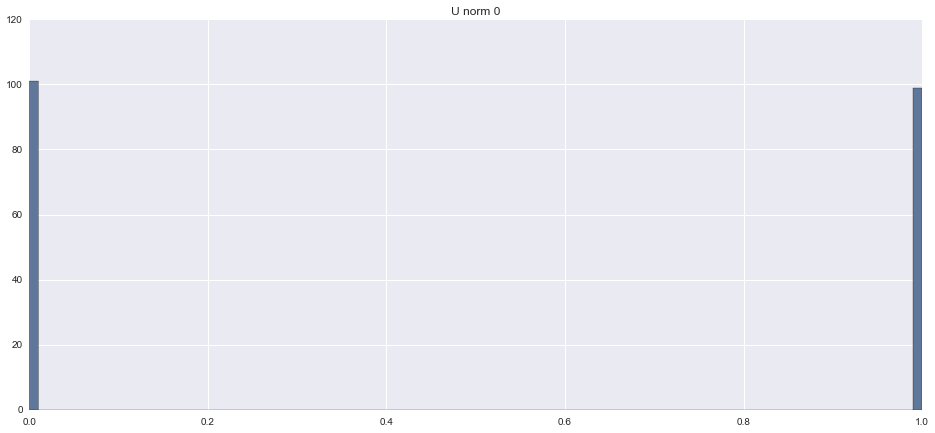

In [139]:
print_hist(U_v3)

In [140]:
print rows_ind_v3

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [161]:
for k in range(2):
    print 'Top words for term cluster 0 and doc cluster %s:' % k
    print_top_k_words_term_cluster(V_v3[k][:, 0], X_train_norm.toarray(), count_vect, 30)
    print

    print 'Top words for term cluster 1 and doc cluster %s:' % k
    print_top_k_words_term_cluster(V_v3[k][:, 1], X_train_norm.toarray(), count_vect, 30)
    print

Top words for term cluster 0 and doc cluster 0:
quinta - 1.0 - 1.43675534573
técnico - 1.0 - 3.56462451803
melhor - 1.0 - 4.04988727448
meio - 1.0 - 2.82656856003
meia - 1.0 - 1.29533757942
casa - 1.0 - 3.40081430181
três - 1.0 - 2.96444738924
atleta - 1.0 - 1.84469966099
caso - 1.0 - 1.8529715666
atlético - 1.0 - 1.33512941856
conta - 1.0 - 2.40958508998
ex - 1.0 - 1.64155721116
desde - 1.0 - 1.67547953777
frente - 1.0 - 1.38076539741
quarta - 1.0 - 3.00284722489
gols - 1.0 - 2.69286933272
goleiro - 1.0 - 1.26493364393
neste - 1.0 - 1.95089030972
título - 1.0 - 4.31037511355
quatro - 1.0 - 2.41344692675
santos - 1.0 - 1.08655608931
gol - 1.0 - 3.91517632453
luta - 1.0 - 1.29955925782
apenas - 1.0 - 4.59242923649
partida - 1.0 - 3.73445248798
bayern - 1.0 - 2.19845209453
deixe - 1.0 - 2.16156875952
estádio - 1.0 - 1.15845870874
bem - 1.0 - 3.10801094029
cinturão - 1.0 - 1.33854908097

Top words for term cluster 1 and doc cluster 0:
útil - 1.0 - 0.0462847202446
empregos - 1.0 - 0.055614

In [144]:
def print_top_k_words(vec, count_vect, k):
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]

    top_pairs = reverse(zip(top_words, top_vals))
    for word, value in top_pairs:
        print '%s - %s' % (word, value)

for i in range(2):
    clust_inds = np.where(rows_ind_v3 == i)[0]
    sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
    print 'Top words for document cluster %s' % i
    print_top_k_words(sum_per_word, count_vect, 20)
    print

Top words for document cluster 0
time - 4.59686045592
feira - 4.48020712845
jogo - 4.38957008659
equipe - 4.29628349948
minutos - 4.28575586041
anos - 3.98431219202
gol - 3.85918707343
ufc - 3.81179311267
brasileiro - 3.80965457051
jogador - 3.75606444219
técnico - 3.52244206397
euro - 3.4981714608
real - 3.48278546656
final - 3.45630089184
breno - 3.34439260137
futebol - 3.26424112787
partida - 3.22656298568
campeão - 3.13847171673
campeonato - 3.10315657868
paulo - 3.09565350225

Top words for document cluster 1
jogo - 13.0195645784
jogos - 12.3527084592
of - 6.59321080468
playstation - 6.50286252979
xbox - 5.93517551309
games - 5.41506727974
game - 5.29370574087
novo - 4.93748565046
console - 4.56307259533
sony - 4.15619803355
the - 3.97710024088
wii - 3.89686450689
brasil - 3.6993005896
league - 3.42599673135
nintendo - 3.27248181662
legends - 3.23393553266
apenas - 2.82897655817
one - 2.70936450188
dia - 2.69523330746
lançado - 2.55713526763



In [145]:
best = 1e10
for _ in xrange(5):
    U_t, S_t, V_t, V_t_t, rows_ind_t, error = matrix_factorization_overlapping_bin(X_train_norm.toarray(), 3, 2, num_iters=100)
    try:
        dav_sc = davies_bouldin_score(X_train_norm.toarray(), rows_ind_t, calculate_centroids_doc_mean(X_train_norm, rows_ind_t, 3))
    except:
        continue
    if error < best:
        best = error
        U_v4 = U_t
        S_v4 = S_t
        V_v4 = V_t
        V_t_v4 = V_t_t
        rows_ind_v4 = rows_ind_t

    print 'tf norm (2 clusters): %s' % rand_score(labels, rows_ind_t)
    print 'tf norm (2 clusters): %s' % sil_score(X_train_norm, rows_ind_t)
    print 'tf norm (2 clusters): %s' % dav_sc
    print ''

tf norm (2 clusters): Rand score: 0.911626468863
tf norm (2 clusters): Silhouette score: 0.0263247804924
tf norm (2 clusters): 4.67652655528

tf norm (2 clusters): Rand score: 0.97014853758
tf norm (2 clusters): Silhouette score: 0.0275417678727
tf norm (2 clusters): 3.75016662057

tf norm (2 clusters): Rand score: 0.767871887193
tf norm (2 clusters): Silhouette score: 0.02801993876
tf norm (2 clusters): 5.32959729825

tf norm (2 clusters): Rand score: 0.734036996152
tf norm (2 clusters): Silhouette score: 0.0271920028126
tf norm (2 clusters): 5.29653960277

tf norm (2 clusters): Rand score: 0.721365663243
tf norm (2 clusters): Silhouette score: 0.0220293220506
tf norm (2 clusters): 4.68667761473



In [199]:
S_v4

array([[ 0.0234421 ,  0.00131716],
       [ 0.03638007,  0.00135596],
       [ 0.00124627,  0.02218215]])

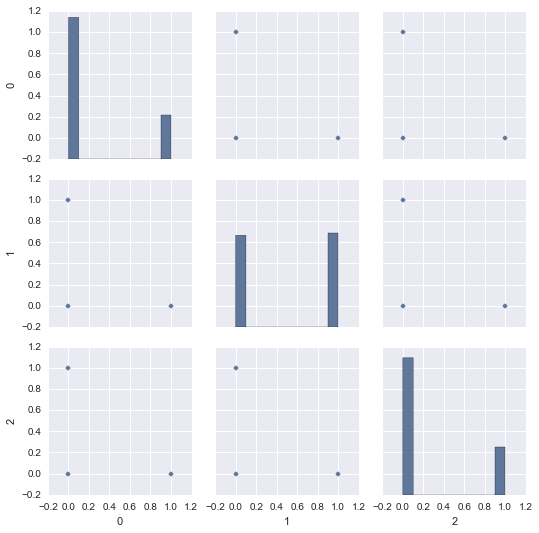

In [147]:
pairplot(U_v4)

In [200]:
for k in range(3):
    print 'Top words for term cluster 0 and doc cluster %s:' % k
    print_top_k_words_term_cluster(V_v4[k][:, 0], X_train_norm.toarray(), count_vect, 50)
    print

    print 'Top words for term cluster 1 and doc cluster %s:' % k
    print_top_k_words_term_cluster(V_v4[k][:, 1], X_train_norm.toarray(), count_vect, 50)
    print

Top words for term cluster 0 and doc cluster 0:
esquerdo - 1.0 - 0.651365168984
final - 1.0 - 4.9373205725
frente - 1.0 - 1.38076539741
técnico - 1.0 - 3.56462451803
frança - 1.0 - 0.95542966429
três - 1.0 - 2.96444738924
partida - 1.0 - 3.73445248798
apenas - 1.0 - 4.59242923649
apesar - 1.0 - 2.15949278802
competição - 1.0 - 2.05481368611
lesão - 1.0 - 1.42526313009
renan - 1.0 - 0.889024737333
flamengo - 1.0 - 0.991778089951
argentino - 1.0 - 1.21561454948
comente - 1.0 - 2.33907203032
liga - 1.0 - 2.53157804296
dois - 1.0 - 4.46835594418
ucrânia - 1.0 - 0.913929173483
fim - 1.0 - 1.91502163193
domingo - 1.0 - 0.928393334169
artilharia - 1.0 - 0.669287812052
artilheiro - 1.0 - 0.703227444938
ficou - 1.0 - 1.14806484749
torneio - 1.0 - 2.52315652071
fez - 1.0 - 2.61110358594
torcida - 1.0 - 1.41509273528
resultado - 1.0 - 1.22373105365
torcedores - 1.0 - 2.83342620539
logo - 1.0 - 1.39549395
duas - 1.0 - 2.24847688731
duelo - 1.0 - 1.50055422439
clássico - 1.0 - 1.01844508683
título 

In [157]:
print 'Num elems in cluster 0: %s' % np.sum(rows_ind_v4 == 0)
print 'Num elems in cluster 1: %s' % np.sum(rows_ind_v4 == 1)
print 'Num elems in cluster 2: %s' % np.sum(rows_ind_v4 == 2)
print rows_ind_v4
print np.where(rows_ind_v4 == 2)

for url in sport_news_df.ix[np.where(rows_ind_v4 == 2)[0]-100].url:
    print url

Num elems in cluster 0: 47
Num elems in cluster 1: 101
Num elems in cluster 2: 52
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 2 1 2 0
 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 2 0 0 0 0 0 0 2 2 0 2 2 2 2 2 2 2 0 0 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 2 0 0 2 2 2 0 0 2 2 2 0 0 2 2 0
 0 0 0 2 0 0 2 0 0 2 0 2 0 2 2]
(array([107, 109, 117, 118, 119, 120, 121, 122, 128, 135, 136, 138, 139,
       140, 141, 142, 143, 144, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 163, 165, 166, 167, 168, 169, 172,
       173, 174, 177, 178, 179, 182, 183, 188, 191, 194, 196, 198, 199]),)
http://esporte.ig.com.br/maisesportes/vela/2014-10-11/com-festa-sete-barcos-partem-em-direcao-a-cidade-do-cabo-na-largada-da-volvo.html
http://esporte.ig.com.br/basquete/2014-10-11/rio-volta-a-receber-a-nba-e-fas-formam

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  101.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <a list of 50 Patch objects>)

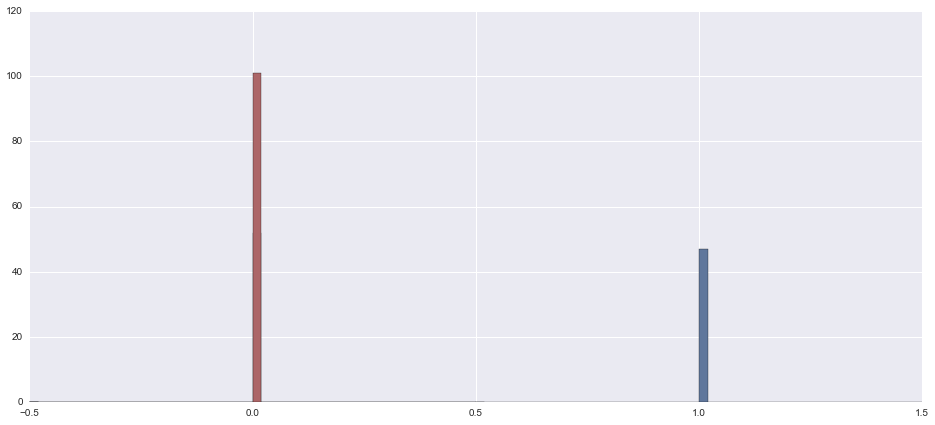

In [158]:
inds = np.where(rows_ind_v4 == 0)[0]
plt.hist(norm(U_v4)[inds, 0], bins=50)

inds = np.where(rows_ind_v4 == 2)[0]
plt.hist(norm(U_v4)[inds, 0], bins=50)

inds = np.where(rows_ind_v4 == 1)[0]
plt.hist(norm(U_v4)[inds, 0], bins=50)

In [159]:
def print_top_k_words(vec, count_vect, k):
    top_inds, top_vals = top_k(vec, k)
    words = count_vect.get_feature_names()
    top_words = [words[i] for i in top_inds]

    top_pairs = reverse(zip(top_words, top_vals))
    for word, value in top_pairs:
        print '%s - %s' % (word, value)

for i in range(3):
    clust_inds = np.where(rows_ind_v4 == i)[0]
    sum_per_word = np.sum(X_train_norm.toarray()[clust_inds, :], axis=0)
    print 'Top words for document cluster %s' % i
    print_top_k_words(sum_per_word, count_vect, 20)
    print

Top words for document cluster 0
minutos - 4.05430795115
gol - 3.47540763664
jogo - 3.00859499708
gols - 2.58109919032
bola - 2.56517677888
euro - 2.50224519934
time - 2.49417849529
partida - 2.42022462049
tempo - 2.3805084019
real - 2.22332618913
feira - 2.15254516838
equipe - 2.08617661635
dois - 2.07200269657
pontos - 2.0671860148
segundo - 2.04539924898
rodada - 2.00205504069
grupo - 1.89237620602
espanha - 1.88008972379
vitória - 1.85527390016
espanhol - 1.79768171206

Top words for document cluster 1
jogo - 13.0195645784
jogos - 12.3527084592
of - 6.59321080468
playstation - 6.50286252979
xbox - 5.93517551309
games - 5.41506727974
game - 5.29370574087
novo - 4.93748565046
console - 4.56307259533
sony - 4.15619803355
the - 3.97710024088
wii - 3.89686450689
brasil - 3.6993005896
league - 3.42599673135
nintendo - 3.27248181662
legends - 3.23393553266
apenas - 2.82897655817
one - 2.70936450188
dia - 2.69523330746
lançado - 2.55713526763

Top words for document cluster 2
breno - 3.344